### Go look at the ones in the EagleSimScripts folder

# PSF Modelling

## Define the PSF module

We base our analysis on the prescription given in Racine (1996). The PSF is specified by its total flux and by its FWHM. Various profiles are then provided as methods of the PSF class. Note that these methods return functions.

In [5]:
%%writefile PSF.py

import numpy as np
import matplotlib.pylab as plt
import warnings

class PSF(object):

    """This class generates representations of various point-spread
    functions."""

    def __init__(self, flux, fwhm):
        self.flux = flux
        self.fwhm = fwhm

    def moffat_profile(self, beta=4.765, flux_fraction=1.0):
        """Profile with default beta suggested by Trujillo et al. 2001. This
            value of beta corresponds to Kolmogorov turbulence."""
        def moffat(theta):
            totalflux = flux_fraction*self.flux
            fwhm = self.fwhm
            ibeta = 1.0/beta
            alpha = fwhm/(2.0*np.sqrt(2.0**ibeta - 1.0))
            coefficient = totalflux*(beta-1.0)/(np.pi*(alpha**2))
            firstMoffat = coefficient * (1 + (theta/alpha)**2)**(-beta)
            return firstMoffat
        return moffat

    def two_moffat_profile(self, flux_fraction=1.0):
        """Simple analytical expression given by Racine (1996) to model the
        CCD-based PSF. Racine's analysis did not go far enough out to contain
        the full aureole component given by King (1971), which was determined
        photographically."""
        def two_moffat(theta):
            totalflux = flux_fraction*self.flux
            fwhm = self.fwhm

            # The first Moffat profile
            flux = 0.8*totalflux
            beta = 7.0
            ibeta = 1.0/beta
            alpha = fwhm/(2.0*np.sqrt(2.0**ibeta - 1.0))
            coefficient = flux*(beta-1.0)/(np.pi*(alpha**2))
            firstMoffat = coefficient * (1 + (theta/alpha)**2)**(-beta)

            # The second Moffat profile
            flux = 0.2*totalflux
            beta = 2.0
            ibeta = 1.0/beta
            alpha = fwhm/(2.0*np.sqrt(2.0**ibeta - 1.0))
            coefficient = flux*(beta-1.0)/(np.pi*(alpha**2))
            secondMoffat = coefficient * (1 + (theta/alpha)**2)**(-beta)

            # The total profile
            return firstMoffat + secondMoffat
        return two_moffat

    def aureole_profile(self, d0=50, flux_fraction=1.0):
        """Analytical function suggested by Racine (1996) for modelling the full
        PSF aureole. The default value of d0 matches the photographic data of
        King (1971). Note that d0 is specified in units of the FWHM. (It is 50
        and not 100 as in the Racine paper because it is in units of FWHM and
        not HW). Note that constructing a PSF with an Aureole will change the
        effective PSF (likely by a very small amount, assuming only a small
        fraction of the light is in the aureole) but this will not be correctly
        captured by the fwhm property of the PSF."""
        def aureole(theta):
            totalflux = flux_fraction*self.flux
            fwhm = self.fwhm
            print fwhm
            d = d0 * fwhm
            coeff = totalflux/(8*np.pi*d**2)
            cosfac = np.cos(np.arctan(theta/(2*d)))
            return coeff*(cosfac**3.0)
        return aureole



Overwriting PSF.py


## Examples

In [6]:
%run PSF.py
%matplotlib inline

---

### Example 1

Try to reproduce Figure 3 in Racine (1996), who show the PSF as a function of radius in units of the Half-Width. We can generate this by setting the FWHM = 2 (i.e. two half-width units). He shows a two-moffat model with a single moffat model for comparison. Note that PSF does not include the very wide-angle power-law aureole that is described by King (1971). To make this clear, I will draw that too, even though it's not in Racine's figure.

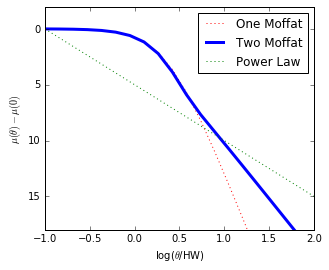

In [7]:
foo=PSF(1.0,2.0);
profile1 = foo.moffat_profile(beta=4)
profile2 = foo.two_moffat_profile()

x = 10.0**np.linspace(-1.0, 2.0, 20)
y1 = 2.5*np.log10(profile1(x[0]))-2.5*np.log10(profile1(x))  # One moffat
y2 = 2.5*np.log10(profile2(x[0]))-2.5*np.log10(profile2(x))  # Two moffat
y3 = 2.5*np.log10(x[0]**(-2.0))-2.5*np.log10(x**(-2.0))      # Power law
plt.plot(np.log10(x),y1,'r:', label="One Moffat")
plt.plot(np.log10(x),y2,'b', label="Two Moffat", linewidth=3)
plt.plot(np.log10(x),y3,'g:', label="Power Law")
plt.legend()

# Ignore Unicode equal comparison warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.gca().set_ylim(ymin=-2)
    plt.gca().set_ylim(ymax=18)
    xl0,xl1 = plt.gca().get_xlim()
    yl0,yl1 = plt.gca().get_ylim()
    plt.gca().set_aspect(0.83*(xl1-xl0)/(yl1-yl0))
    plt.gca().set_xlabel(r'log($\theta$/HW)')
    plt.gca().set_ylabel(r'$\mu(\theta) - \mu(0)$')
    plt.gca().invert_yaxis()

--------

### Example 2

Racine (1991) also provides a simple model for the aureole, based on a physical model for a single reflection. His figure is reproduced below, along with a few extra curves (such as a fiducial power law to show how the aureole model approximates this). Note that he thinks the origin of the aureole is unclear. He thinks it is a reflection (perhaps internal to an emuslion) in the photographic data, but for the CCD data (in which only the innermost part of the aureole is seen) he thinks its probably due to light cirrus in Tonry's data (which he uses, in addition to his own CCD data).

2.0
2.0
2.0
2.0


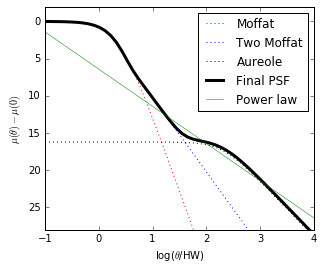

In [13]:
foo=PSF(1.0,2.0);
profile1 = foo.moffat_profile(beta=4)
profile2 = foo.two_moffat_profile()
profile3 = foo.aureole_profile()

def profile4(x):
    p1 = foo.two_moffat_profile(flux_fraction=0.98)
    p2 = foo.aureole_profile(flux_fraction=0.02)
    return p1(x) + p2(x)

x = 10.0**np.linspace(-1.0, 4.0, 50)
y1 = 2.5*np.log10(profile1(x[0]))-2.5*np.log10(profile1(x))         # Moffat
y2 = 2.5*np.log10(profile2(x[0]))-2.5*np.log10(profile2(x))         # Two Moffat
y3 = 16.2 + 2.5*np.log10(profile3(x[0]))-2.5*np.log10(profile3(x))  # Pure Aureole
y4 = 2.5*np.log10(profile4(x[0]))-2.5*np.log10(profile4(x))         # Two Moffat + Aureole
y5 = 1.4 + 2.5*np.log10(x[0]**(-2.0))-2.5*np.log10(x**(-2.0))       # Power law (alpha = -2)
plt.plot(np.log10(x),y1,'r:',label="Moffat")
plt.plot(np.log10(x),y2,'b:',label="Two Moffat")
plt.plot(np.log10(x),y3,'k:',label="Aureole")
plt.plot(np.log10(x),y4,'k', label="Final PSF", linewidth=3)
plt.plot(np.log10(x),y5,'g-',label="Power law", linewidth=0.5)

# Ignore Unicode equal comparison warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.gca().set_ylim(ymin=-2)
    plt.gca().set_ylim(ymax=28)
    xl0,xl1 = plt.gca().get_xlim()
    yl0,yl1 = plt.gca().get_ylim()
    plt.gca().set_aspect(0.83*(xl1-xl0)/(yl1-yl0))
    plt.gca().set_xlabel(r'log($\theta$/HW)')
    plt.gca().set_ylabel(r'$\mu(\theta) - \mu(0)$')
    plt.gca().invert_yaxis()
    plt.legend()

---

### Example 3

Compare with the PSF from the first Dragonfly paper.

In [5]:
def generate_psf_model(fwhm = 3.0, aureole_fraction = 0.02, d0 = 50):
    unitFluxPSF = PSF(1.0,fwhm);
    def profile(x):
        p1 = unitFluxPSF.two_moffat_profile(flux_fraction=(1.0 - aureole_fraction))
        p2 = unitFluxPSF.aureole_profile(flux_fraction=aureole_fraction, d0 = d0)
        return p1(x) + p2(x)
    return profile

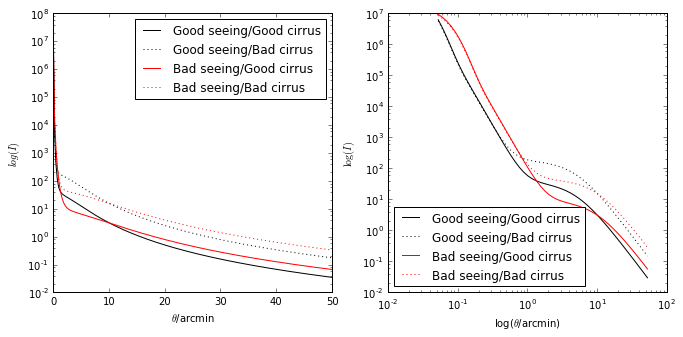

In [6]:
good_seeing_good_cirrus = generate_psf_model(fwhm = 3.0)
bad_seeing_good_cirrus = generate_psf_model(fwhm = 6.0)
good_seeing_bad_cirrus = generate_psf_model(fwhm = 3.0, aureole_fraction = 0.1)
bad_seeing_bad_cirrus = generate_psf_model(fwhm = 6.0, aureole_fraction = 0.1)
coeff = 1.0e9;

plt.figure(figsize=(11, 5))

# Log-linear
plt.subplot(1, 2, 1)
x = np.linspace(1, 3000, 200)
y1 = coeff * good_seeing_good_cirrus(x)
y2 = coeff * good_seeing_bad_cirrus(x)
y3 = coeff * bad_seeing_good_cirrus(x)
y4 = coeff * bad_seeing_bad_cirrus(x)

plt.semilogy(x/60,y1,'k',label="Good seeing/Good cirrus")
plt.semilogy(x/60,y2,'k:',label="Good seeing/Bad cirrus")
plt.semilogy(x/60,y3,'r',label="Bad seeing/Good cirrus")
plt.semilogy(x/60,y4,'r:',label="Bad seeing/Bad cirrus")

plt.gca().set_xlabel(r'$\theta$/arcmin')
plt.gca().set_ylabel(r'$log(I)$')
plt.legend(loc=1)

# Log-Log
plt.subplot(1, 2, 2)
x = 10.0**np.linspace(0.5, 3.5, 50)
y1 = coeff * good_seeing_good_cirrus(x)
y2 = coeff * good_seeing_bad_cirrus(x)
y3 = coeff * bad_seeing_good_cirrus(x)
y4 = coeff * bad_seeing_bad_cirrus(x)

plt.loglog(x/60,y1,'k',label="Good seeing/Good cirrus")
plt.loglog(x/60,y2,'k:',label="Good seeing/Bad cirrus")
plt.loglog(x/60,y3,'r',label="Bad seeing/Good cirrus")
plt.loglog(x/60,y4,'r:',label="Bad seeing/Bad cirrus")

plt.gca().set_xlabel(r'log($\theta$/arcmin)')
plt.gca().set_ylabel(r'$\log(I)$')
plt.legend(loc=3)



## Unit tests 

The following test framework exercises the PSF module. 

In [7]:
%%writefile TestPSF.py

from PSF import PSF
import unittest
import numpy as np
import scipy.integrate as integrate


class TestPSFMethods(unittest.TestCase):

    def test_moffat_normalization(self):

        # Integrals need to be good to 0.1%
        tolerance = 0.001
        fwhm = 2.0

        # Check default
        expected_answer = 1.0
        star = PSF(expected_answer, fwhm)
        profile = star.moffat_profile()
        result = integrate.quad(
            lambda r: (2.0 * np.pi * r) * profile(r), 0, 10000)
        self.assertTrue(
            abs(result[0] - expected_answer) <= tolerance*expected_answer)

        # Check flux parameter
        expected_answer = 1000.0
        star = PSF(expected_answer, fwhm)
        profile = star.moffat_profile()
        result = integrate.quad(
            lambda r: (2.0 * np.pi * r) * profile(r), 0, 10000)
        self.assertTrue(
            abs(result[0] - expected_answer) <= tolerance*expected_answer)

        # Check that correct normalization does not depend on beta
        expected_answer = 1000.0
        star = PSF(expected_answer, fwhm)
        profile = star.moffat_profile(beta=3)
        result = integrate.quad(
            lambda r: (2.0 * np.pi * r) * profile(r), 0, 10000)
        self.assertTrue(
            abs(result[0] - expected_answer) <= tolerance*expected_answer)

    def test_two_moffat_normalization(self):

        # Integrals need to be good to 0.1%
        tolerance = 0.001
        fwhm = 2.0

        # Check default case
        expected_answer = 1.0
        star = PSF(expected_answer, fwhm)
        profile = star.two_moffat_profile()
        result = integrate.quad(
            lambda r: (2.0 * np.pi * r) * profile(r), 0, 10000)
        self.assertTrue(
            abs(result[0] - expected_answer) <= tolerance*expected_answer)

        # Check flux parameter
        expected_answer = 1000.0
        star = PSF(expected_answer, fwhm)
        profile = star.two_moffat_profile()
        result = integrate.quad(
            lambda r: (2.0 * np.pi * r) * profile(r), 0, 10000)
        self.assertTrue(
            abs(result[0] - expected_answer) <= tolerance*expected_answer)

    def test_aureole_normalization(self):

        # Integrals only need to be good to 5%
        tolerance = 0.05
        fwhm = 1.0

        # Check default case
        expected_answer = 1.0
        star = PSF(expected_answer, fwhm)
        profile = star.aureole_profile()
        result = integrate.quad(
            lambda r: (2.0 * np.pi * r) * profile(r), 0, 10000)
        self.assertTrue(
            abs(result[0] - expected_answer) <= tolerance*expected_answer)

        # Check flux parameter
        expected_answer = 1000.0
        star = PSF(expected_answer, fwhm)
        profile = star.aureole_profile()
        result = integrate.quad(
            lambda r: (2.0 * np.pi * r) * profile(r), 0, 10000)
        self.assertTrue(
            abs(result[0] - expected_answer) <= tolerance*expected_answer)

    def test_composite_normalization(self):

        # Integrals only need to be good to 5%
        tolerance = 0.05

        # Check default case
        fwhm = 2.0
        expected_answer = 1000
        star = PSF(expected_answer, fwhm)

        def profile(x):
            p1 = star.two_moffat_profile(flux_fraction=0.9)
            p2 = star.aureole_profile(flux_fraction=0.1)
            return p1(x) + p2(x)

        result = integrate.quad(
            lambda r: (2.0 * np.pi * r) * profile(r), 0, 10000)
        self.assertTrue(
            abs(result[0] - expected_answer) <= tolerance*expected_answer)

    def test_fwhm(self):

        # Define the star
        flux = 1.0
        fwhm = 3.0
        star = PSF(flux, fwhm)

        # The measured FWHM of the star should always be within
        # 0.1% of expectation
        tolerance = 0.001

        # The value at FWHM/2.0 should always be half the central value
        expected_answer = 0.5

        # Check that the FWHM of a single Moffat PSF profile is correct.
        # Remember the default PSF has unity totql _flux_ not unity at x=0
        profile = star.moffat_profile()
        result = profile(fwhm/2.0)/profile(0.0)
        self.assertTrue(
            abs(result - expected_answer) <= tolerance*expected_answer)

        # Check that the FWHM of the two Moffat PSF profile is correct
        profile = star.two_moffat_profile()
        result = profile(fwhm/2.0)/profile(0.0)
        self.assertTrue(
            abs(result - expected_answer) <= tolerance*expected_answer)

        # Check that adding a 5% extended aureole to create a composite PSF
        # does not change the FWHM by very much.
        def cprofile(x):
            p1 = star.two_moffat_profile(flux_fraction=0.95)
            p2 = star.aureole_profile(flux_fraction=0.05)
            return p1(x) + p2(x)
        result = cprofile(fwhm/2.0)/cprofile(0.0)
        self.assertTrue(
            abs(result - expected_answer) <= tolerance*expected_answer)

if __name__ == '__main__':
    unittest.main()

Overwriting TestPSF.py


In [8]:
%run TestPSF.py

.....
----------------------------------------------------------------------
Ran 5 tests in 0.039s

OK
